In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from IPython.display import display
import torch
import pickle

In [4]:
#import torch
from torch.utils.data import Dataset

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "real"]
        self.folder = folder_name
        #self.classes = ["T2C", "ECL"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            rrl_data.sort_values(by="mjd", inplace=True)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            while len(rrl_data) < 335:
                #RELLENAR y label-0;
                rrl_data = rrl_data.append(df_zeros, ignore_index=True)
                #label-1 a los que no son relleno
                rrl_data = rrl_data.fillna(1)
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
        
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))
    
    def __len__(self):
        return len(self.data)


In [5]:
with open('rrab.pkl', 'rb') as handle:
    vvv_rrab = pickle.load(handle)

In [6]:
with open('rrc.pkl', 'rb') as handle:
    vvv_rrc = pickle.load(handle)

In [7]:
with open('ecl_c.pkl', 'rb') as handle:
    vvv_ecl_c = pickle.load(handle)

In [8]:
with open('ecl_nc.pkl', 'rb') as handle:
    vvv_ecl_nc = pickle.load(handle)

In [9]:
with open('ell.pkl', 'rb') as handle:
    vvv_ell = pickle.load(handle)

<IPython.core.display.Javascript object>


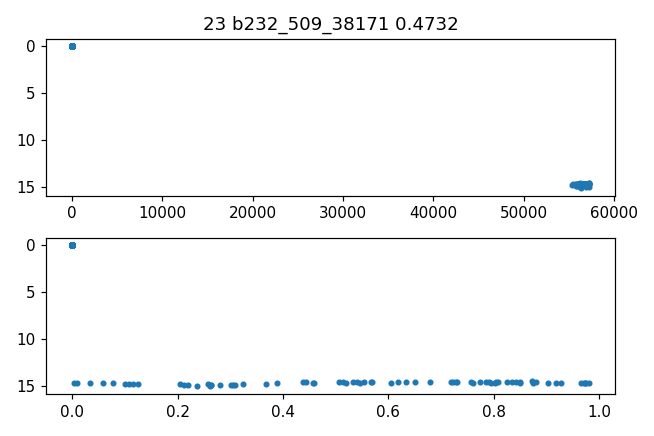

In [11]:
import ipywidgets as widgets

k = 0
fig, ax = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)        
vvv_rrab.plot(k, ax)
b1 = widgets.Button(description="Prev")
b2 = widgets.Button(description="Next")
display(widgets.HBox([b1, b2]))

def on_button_clicked(b):
    global k
    if b.description == "Next":
        k +=1
    else:
        if k>0:
            k-=1
    vvv_rrab.plot(k, ax)

b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)

In [19]:
VVV = [vvv_ecl_c,vvv_ecl_nc,vvv_ell,vvv_rrab,vvv_rrc]
VVV_len = [len(i) for i in VVV]

<IPython.core.display.Javascript object>


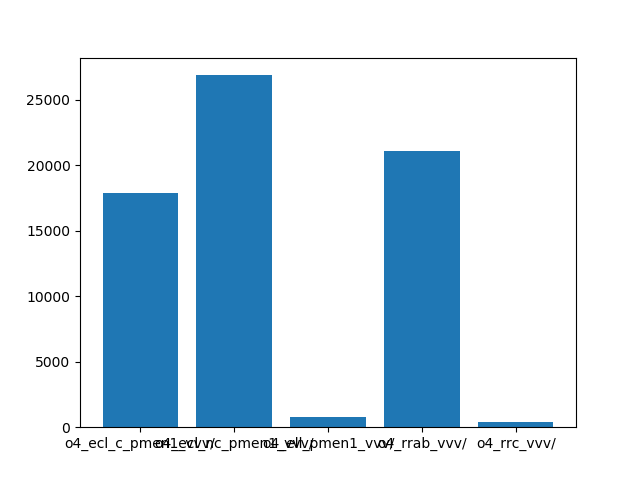

<BarContainer object of 5 artists>

In [28]:
plt.bar(range(5),VVV_len, tick_label=[i.folder for i in VVV])

In [27]:
for i in VVV:
    display(i.folder)

'o4_ecl_c_pmen1_vvv/'

'o4_ecl_nc_pmen1_vvv/'

'o4_ell_pmen1_vvv/'

'o4_rrab_vvv/'

'o4_rrc_vvv/'

In [29]:
plt.bar?